In [1]:
import numpy as np
import gpstk
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numba import autojit
from numpy.linalg import norm
%matplotlib inline

In [2]:
#functions for calculate position
@autojit
def apply_earth_rotation_to_svs_position(svs, prs):
    c = 299792458
    we = 7.2921159e-5
    rpos = np.zeros(svs.shape)
    pos = np.array(svs)
    for i in range(len(pos)):
        dt = prs[i]/c
        theta = we*dt
        R = np.array([[np.cos(theta), np.sin(theta),0.],[-np.sin(theta), np.cos(theta),0.],[0.,0.,1.]])
        rpos[i] = R.dot(pos[i])
    svs = np.array(rpos)
    return svs
@autojit
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1) #raiz cuadrada de la suma de los cuadrados de los puntos para medir distancia.
@autojit
def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = 299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    #print "rhos: ",rhos
    #print "pranges: ", pranges
    return rhos, pranges
def compute_least_squares_position(svs, svs_clocks, prs, max_iters=200, apply_earth_rotation=True):

    #if apply_earth_rotation:
    svs = apply_earth_rotation_to_svs_position(svs, prs)
    
    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters): #mientras el delta < 1e-8 y no llegue al maximo de iteraciones
        rhos, pranges = predict_pseudoranges(ri, svs, svs_clocks)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta
def to_skyplot(elevation, azimut):
    e = np.array(elevation)
    a = np.array(azimut)
    sx = ((90-e)/90) * np.sin (a * (np.pi/180))
    sy = ((90-e)/90) * np.cos (a * (np.pi/180))
    return (sx,sy)
def compute_raim_position(gps_week, gps_sow, prns, prns_pos, pranges,  bcestore):
    if len(prns)==0 or len(prns_pos)==0:
        return np.array([0,0,0])
    t = gpstk.GPSWeekSecond(gps_week, gps_sow).toCommonTime()
    prnList = [gpstk.SatID(int(i[3:])) for i in prns]
    satVector = gpstk.seqToVector(list(prnList), outtype='vector_SatID')
    rangeVector = gpstk.seqToVector([float(i) for i in pranges])
    noTropModel = gpstk.ZeroTropModel()
    raimSolver = gpstk.PRSolution2()
    raimSolver.RAIMCompute(t, satVector, rangeVector, bcestore, noTropModel)   
    r = np.array([raimSolver.Solution[0], raimSolver.Solution[1], raimSolver.Solution[2]])
    return r
def To_WGS83(pos):
    newPosPZ = np.array([pos[0]-0.36,pos[1]+0.08,pos[2]+0.18])
    return newPosPZ

In [3]:
from numpy import (sin, cos, tan, sqrt, radians, arctan2, hypot, degrees, mod,
                   atleast_2d, atleast_1d, empty_like, array, column_stack)
class EarthEllipsoid:

    def __init__(self):
        self.a = 6378137.  # semi-major axis [m]
        self.f = 1 / 298.2572235630  # flattening
        self.b = self.a * (1 - self.f)  # semi-minor axis

def _depack(x0):
    m, n = x0.shape

    assert x0.ndim == 2 and (m==3 or n==3),'I expect Nx3 or 3XN triplets'

    if m == 3:  # 3xN triplets
        x = x0[0, :]
        y = x0[1, :]
        z = x0[2, :]
    elif n == 3:  # Nx3 triplets
        x = x0[:, 0]
        y = x0[:, 1]
        z = x0[:, 2]
    else:
        raise TypeError('I expect an Nx3 or 3xN input of x,y,z')
    return x, y, z

def get_radius_normal(lat_radians, ell):
    a = ell.a
    b = ell.b
    return a**2 / sqrt(
        a**2 * (cos(lat_radians))**2 + b**2 *
        (sin(lat_radians))**2)

def ecef2geodetic(x, y=None, z=None, ell=EarthEllipsoid(), deg=True):
    if y is None:
        x, y, z = _depack(x)
    """Algorithm is based on
    http://www.astro.uni.torun.pl/~kb/Papers/geod/Geod-BG.htm
    This algorithm provides a converging solution to the latitude
equation
    in terms of the parametric or reduced latitude form (v)
    This algorithm provides a uniform solution over all latitudes as it
does
    not involve division by cos(phi) or sin(phi)
    """
    ea = ell.a
    eb = ell.b
    rad = hypot(x, y)
# Constant required for Latitude equation
    rho = arctan2(eb * z, ea * rad)
# Constant required for latitude equation
    c = (ea**2 - eb**2) / hypot(ea * rad, eb * z)
# Starter for the Newtons Iteration Method
    vnew = arctan2(ea * z, eb * rad)
# Initializing the parametric latitude
    v = 0
    count = 0
    while (v != vnew).any() and count < 5:
        v = vnew.copy()
#%% Newtons Method for computing iterations
        vnew = v - ((2 * sin(v - rho) - c * sin(2 * v)) /
                    (2 * (cos(v - rho) - c * cos(2 * v))))
        count += 1

#%% Computing latitude from the root of the latitude equation
    lat = arctan2(ea * tan(vnew), eb)
    # by inspection
    lon = arctan2(y, x)

    alt = ((rad - ea * cos(vnew)) * cos(lat)) + \
        ((z - eb * sin(vnew)) * sin(lat))

    if deg:
        return degrees(lat), degrees(lon), alt
    else:
        return lat, lon, alt  # radians

def geodetic2ecef(lat, lon, alt, ell=EarthEllipsoid(), deg=True):
    if deg:
        lat = radians(lat)
        lon = radians(lon)
    # radius of curvature of the prime vertical section
    N = get_radius_normal(lat, ell)
    # Compute cartesian (geocentric) coordinates given  (curvilinear) geodetic
    # coordinates.
    x = (N + alt) * cos(lat) * cos(lon)
    y = (N + alt) * cos(lat) * sin(lon)
    z = (N * (ell.b / ell.a)**2 + alt) * sin(lat)
    return x, y, z

def _uvw2enu(u, v, w, lat0, lon0, deg):
    if deg:
        lat0 = radians(lat0)
        lon0 = radians(lon0)
    t = cos(lon0) * u + sin(lon0) * v
    East = -sin(lon0) * u + cos(lon0) * v
    Up = cos(lat0) * t + sin(lat0) * w
    North = -sin(lat0) * t + cos(lat0) * w
    return East, North, Up

def ecef2enu(x, y, z, lat0, lon0, h0, ell=EarthEllipsoid(), deg=True):
    x0, y0, z0 = geodetic2ecef(lat0, lon0, h0, ell, deg=deg)
    return _uvw2enu(x - x0, y - y0, z - z0, lat0, lon0, deg=deg)


In [4]:
#aira3630 15-->  Problema en la primer observación
#badg3170 15-->  Tiene un problema al calcular la ephemeris de Glonass
#yell0490.16-->  Mas variado en errores y visibilidad de satélites
#mac11000.16-->  Error in GPS Ephemeris 
#gope2440.16-->  Error in GLONASS Ephemeris
#mac12000.16-->  Error in GPS Ephemeris
#jfng2000.16-->  Error GPS grande, Glonass cerca de 7mil
navfile = "glonass/badg3170.15n" 
obsfile = "glonass/badg3170.15o" 
glofile = "glonass/badg3170.15g" 

### FOR <font color='red'>GPS</font>

In [5]:
navHeader, navData = gpstk.readRinex3Nav(navfile)
# setup ephemeris store to look for satellite positions (GPS)
bcestore = gpstk.GPSEphemerisStore()
GPS_LS = navHeader.leapSeconds
print "LEAP SECONDS GPS", GPS_LS
counter=0
InitialTimeGPS = bcestore.getInitialTime()
print "TIEMPO INICIAL", bcestore.getInitialTime()
print "TIEMPO FINAL", bcestore.getFinalTime()
for navDataObj in navData:
    counter += 1
    ephem = navDataObj.toGPSEphemeris()
    bcestore.addEphemeris(ephem)
    
    if(counter==3):
        print bcestore #print the bcstore for the trhee first ephemeris
bcestore.SearchNear()
print "conteo",counter
navData.close()

LEAP SECONDS GPS 17
TIEMPO INICIAL 3442448 00000000 0.000000000000000 GPS
TIEMPO FINAL 0000000 00000000 0.000000000000000 GPS
Dump of GPSEphemerisStore (detail level=1):
 BCE table for all satellites has 3 entries; Time span is 2015/11/12 08:00:00 GPS to 2015/11/13 04:00:00 GPS
 Search method is User
Sat G01 has   1 entries; Time span is 2015/11/13 00:00:00 GPS to 2015/11/13 00:00:00 GPS
Sat G02 has   1 entries; Time span is 2015/11/12 08:00:00 GPS to 2015/11/12 08:00:00 GPS
Sat G03 has   1 entries; Time span is 2015/11/13 02:00:00 GPS to 2015/11/13 02:00:00 GPS
END Dump of GPSEphemerisStore (detail level=1)

conteo 216


### FOR <font color='red'>GLONASS</font>

In [6]:
navHeader, navData = gpstk.readRinex3Nav(glofile)
# setup ephemeris store to look for satellite positions (GLONASS)
g = gpstk.GloEphemerisStore()
counter=0
Glo_LS = navHeader.leapSeconds #Leap Seconds, info in the header RINEX
timeSix = []

print "LEAP SECONDS Glonass", Glo_LS

for navDataObj in navData:
    counter += 1
    ephem = navDataObj.toGloEphemeris()
    tiempo = ephem.getEphemerisEpoch()
    xvt = ephem.svXvt(tiempo)
    freq = ephem.getfreqNum()
    g.addEphemeris(navDataObj)# object call g, have all the information of the Navigation file
    
    location = gpstk.Position(xvt.x)
    if(ephem.getPRNID() == 10):
        timeSix.append(tiempo.getSecondOfDay()) # keep in a array 
        print "PRN",ephem.getPRNID() #print the Satellite
        print "pos",xvt
        print "FREQ",freq # frequency of the Satellite
        print "--------------------------"
print "conteo",counter
InitialTimeGlo = g.getInitialTime()
FinalTimeGlo = g.getFinalTime()
print "INITIAL TIME", InitialTimeGlo
print "FINAL TIME", FinalTimeGlo
navData.close()

LEAP SECONDS Glonass 17
PRN 10
pos x:(8.80983e+06, 9.73237e+06, 2.18422e+07), v:(-263.557, 2989.33, -1232.21), clk bias:7.15804e-07, clk drift:0, relcorr:3.17742e-09
FREQ -7
--------------------------
PRN 10
pos x:(8.75005e+06, 1.47895e+07, 1.8806e+07), v:(179.511, 2581.57, -2119.57), clk bias:7.1747e-07, clk drift:0, relcorr:2.44205e-09
FREQ -7
--------------------------
PRN 10
pos x:(9.36393e+06, 1.88724e+07, 1.43102e+07), v:(469.966, 1919.09, -2843.25), clk bias:7.19311e-07, clk drift:0, relcorr:1.53245e-09
FREQ -7
--------------------------
PRN 10
pos x:(1.03058e+07, 2.1599e+07, 8.70287e+06), v:(534.845, 1092.12, -3346.49), clk bias:7.20324e-07, clk drift:0, relcorr:5.19479e-10
FREQ -7
--------------------------
PRN 10
pos x:(1.11338e+07, 2.27739e+07, 2.41922e+06), v:(342.01, 215.159, -3589.77), clk bias:7.22297e-07, clk drift:0, relcorr:-5.2159e-10
FREQ -7
--------------------------
PRN 10
pos x:(1.13902e+07, 2.24159e+07, -4.05246e+06), v:(-93.9236, -591.75, -3554.06), clk bias:7.

### <font color='red'>OBSERVATION</font> DATA

In [35]:
observation_types=["P1", "P2", "L1", "L2"]

Elevations = []
Azimuths = []
TimeOfDay = []
NumObservations = []
NumObservationsGlo = []

A_Glonass = []
A_GPS = []


prefix = ""
c = 299792458.
counter=0
gl = 0
observations = 0 # Las primeras "2000" observaciones, para mas observaciones cambiar el número.

obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
print obsHeader.stringFirstTime, obsHeader.firstObs
#real position (of observer)
real_pos = obsHeader.antennaPosition[0], obsHeader.antennaPosition[1], obsHeader.antennaPosition[2]
print "real position",real_pos
#this code for know if have the observation P1,P2,L1,L2, if have not, I can not calculate the position
requested_obstypes = observation_types
obsidxs = []
obstypes = []
obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
for i in requested_obstypes:
    w = np.where(obsdefs==i)[0]
    if len(w)!=0:
        obsidxs.append(w[0])
        obstypes.append(i)
    else:
        print ("WARNING! observation `"+i+"` no present in file")
print "observation types",obsidxs, obstypes


obsHeader, obsData = gpstk.readRinex3Obs(obsfile) # MIXED Observer File (GPS + GLONASS)
for obsObject in obsData: #round the data
    counter += 1 #this counter is for see how much observations of the RINEX
    NumObservations.append(counter)
    try: #Don't see the first observation, because the first observation is of the last day, and thats have an
        #error with the navigation file of Glonass
        observations += 1
        GPSSat = []
        GPSPos = []
        GPSClockBias = []
        GPSRelatCorr = []
        GPSP1 = []

        GloSat = []
        GloPos = []
        GloClockBias = []
        GloRelatCorr = []
        GloP1 = []
        
        Elevations = []
        Azimuths = []
        
        #counter += 1
        TimeOfDay.append(obsObject.time.getSecondOfDay())
        for satID, datumList in obsObject.obs.iteritems():
                
            
                #--------------------GPS----------
            if(satID.system == satID.systemGPS):
                GPSSat.append(str(satID))
                eph   = bcestore.findEphemeris(satID, obsObject.time) #bcestore is a objetc for the ephemeris   
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)
                    #print obsdict #, but I wanna calculate it
                    #obsidxs[0] = 0,  P1
                P1 = obsObject.getObs(satID, obsidxs[0]).data
                
                GPSP1.append(P1)
                
                svTime = obsObject.time - P1/c #Time of signal transmission at satellite
                #print "SEC GPS*",obsObject.time.getSecondOfDay(),"TIME",obsObject.time,"*"
                svXvt = eph.svXvt(svTime)
                svTime += - svXvt.getClockBias() + svXvt.getRelativityCorr() #minus error clock_bias, plus 
                svXvt = eph.svXvt(svTime)

                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]]

                elevGPS = obsHeader.antennaPosition.elvAngle(svXvt.getPos())
                azimGPS = obsHeader.antennaPosition.azAngle(svXvt.getPos())
                
                #if(elevGPS >10):
                GPSPos.append(pos_prn)
                GPSClockBias.append(svXvt.getClockBias())
                GPSRelatCorr.append(svXvt.getRelativityCorr())

                A_GPS.append([GPSSat,GPSP1,GPSPos,GPSClockBias,elevGPS,azimGPS])
                #--------------------GLONASS------------------
            elif(satID.system == satID.systemGlonass):
                gl += 1
                
                #P1 distance in meters
                obsdict = {}
                for i in obstypes:
                    obsdict[i]=[]
                for i in range(len(obsidxs)): #get it all the distance of each type of observation
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)

                
                P1 = obsObject.getObs(satID, obsidxs[0]).data              
                GloTime = obsObject.time #Time of the observation
                GloTime.setTimeSystem(gpstk.TimeSystem('GLO')) #Trasform time of the observation to GLONASS type (just the type)
                svTime = GloTime - P1/c  # Time of signal transmission at satellite, almost 0.07 secs
                '''In the GLONASS system, 'clkbias' already includes the relativistic
                     correction, therefore we must substract the late from the former.
                ORIGINAL CODE: sv.relcorr = sv.computeRelativityCorrection();
                ORIGINAL CODE: sv.clkbias = clkbias + clkdrift * (epoch - ephTime) - sv.relcorr;
                ''' 
                svTime += - svXvt.getClockBias()  - Glo_LS # minus Leap Seconds (Glo_LS)
                eph   = g.findEphemeris(satID,svTime) #search in the navigation file the Glonass Ephemeris
                svXvt = eph.svXvt(svTime) #with RungeKutta Method (4RK) know the position X,Y,Z
                pos_prn = [svXvt.x[0], svXvt.x[1], svXvt.x[2]] #resultant position
                elevG = obsHeader.antennaPosition.elvAngle(svXvt.getPos())#Elevation
                azimG = obsHeader.antennaPosition.azAngle(svXvt.getPos())#Azimuth
                Elevations.append(elevG)
                Azimuths.append(azimG)
        
                GloSat.append(str(satID))
                GloP1.append(P1)
                GloPos.append(pos_prn)
                GloClockBias.append(svXvt.getClockBias())
                GloRelatCorr.append(svXvt.getRelativityCorr())
                A_Glonass.append([GloSat,GloP1,GloPos,GloClockBias,Elevations,Azimuths])
    except(Exception):
        #A_Glonass.append([GloSat,GloP1,GloPos,GloClockBias,Elevations,Azimuths])
        NumObservationsGlo.append(counter) #las observaciones que se puede calcular GLONASS
        print "observation ",counter," without Navigation info", obsObject.time
        #This happens because the information of the navigation file of glonass have not all info enough to the observation file

names=["PRN","P1", "POS", "CLOCK","ELEV","AZIM"]
A_GPS = pd.DataFrame(A_GPS, columns=names)
A_Glonass = pd.DataFrame(A_Glonass, columns=names)
        
                

TIME OF FIRST OBS 11/13/2015 00:00:00 GPS
real position (-838281.8325, 3865775.216, 4987623.8898)
observation types [1, 2, 3, 4] ['P1', 'P2', 'L1', 'L2']
observation  1  without Navigation info 2457340 00000000 0.000000000000000 GLO
observation  2543  without Navigation info 2457340 75630000 0.000000000000000 GLO
observation  2544  without Navigation info 2457340 75660000 0.000000000000000 GLO
observation  2545  without Navigation info 2457340 75690000 0.000000000000000 GLO
observation  2546  without Navigation info 2457340 75720000 0.000000000000000 GLO
observation  2547  without Navigation info 2457340 75750000 0.000000000000000 GLO
observation  2548  without Navigation info 2457340 75780000 0.000000000000000 GLO
observation  2549  without Navigation info 2457340 75810000 0.000000000000000 GLO
observation  2550  without Navigation info 2457340 75840000 0.000000000000000 GLO
observation  2551  without Navigation info 2457340 75870000 0.000000000000000 GLO
observation  2552  without Na

### Position for GPS - <font color='red'>Last Observation</font> 

Last Observation

In [8]:
print GPSSat # GPS
p1 = np.array(GPSP1)
pos = np.array(GPSPos)
clock = np.array(GPSClockBias)

['GPS 1', 'GPS 3', 'GPS 6', 'GPS 11', 'GPS 17', 'GPS 19', 'GPS 24', 'GPS 28', 'GPS 32']


In [9]:
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)#With Least Squares, search the 

In [10]:
print "real                  ", real_pos
print "LS computed           ", ls_computed_pos[:3]
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - real_pos)," distance"
c = 299792458.
print "receiver clock bias   ", ls_computed_pos[3]/c, "secs ==", ls_computed_pos[3], "meters"
print "satellite clock biases", clock

real                   (-838281.8325, 3865775.216, 4987623.8898)
LS computed            [ -838285.30157569  3865797.86758464  4987642.89071869]
LS error               29.7685015337  distance
receiver clock bias    0.000247304901203 secs == 74140.1442071 meters
satellite clock biases [  4.40652883e-06   1.38218609e-05   9.46180882e-05  -6.15989259e-04
  -1.93917158e-04  -5.22727133e-04  -7.92134706e-06   4.81248289e-04
   1.61175785e-05]


### Position for <font color='blue'>GPS</font> -  <font color='red'>All Observations</font>

In [75]:
positionGPS = []
erroresGPS = []
NormErroesGPS = []
vistos = []
Elevations = []
c = 299792458.
SumError = 0.
posXYGPS = []
sumaErroresMayoDiezmil = 0
XObservationError = []
Errores = []


for i in range (0, observations):
    p1 = np.array(A_GPS.P1[i])
    pos = np.array(A_GPS.POS[i])
    clock = np.array(A_GPS.CLOCK[i])
    vistos.append(len(A_GPS.PRN[i]))
    Elevations.append(A_GPS.ELEV[i])
    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos) #Absoute error in position 
    
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil
        lastError = ls_error
        posXYGPS.append([ls_computed_pos[:1],ls_computed_pos[1:2],ls_computed_pos[1:2]])
        pos_cpu = ls_computed_pos[:3]
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionGPS.append([pos_cpu,ls_error,reciverBias])
        erroresGPS.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1#quantity of errors of > 10mil
        XObservationError.append(i)
        Errores.append(lastError)
        erroresGPS.append(lastError)

names=["X","Y","Z" ]
posXYGPS = pd.DataFrame(posXYGPS, columns=names)        
print "Average Error Position for GPS: ", SumError/observations, "[meters]"
print "Maximum Error: ",max(erroresGPS), "[meters]"
print "Minimum Error: ",min(erroresGPS), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGPS = pd.DataFrame(positionGPS,columns=names)
print "Average Error: ", reduce(lambda x, y: x + y, erroresGPS) / len(erroresGPS), "how much: ",len(erroresGPS)-sumaErroresMayoDiezmil

Average Error Position for GPS:  23.0817763224 [meters]
Maximum Error:  38.6677839781 [meters]
Minimum Error:  18.8860216446 [meters]
Errores de posición superiores a 10mil:  503
Average Error:  27.8513127806 how much:  2400


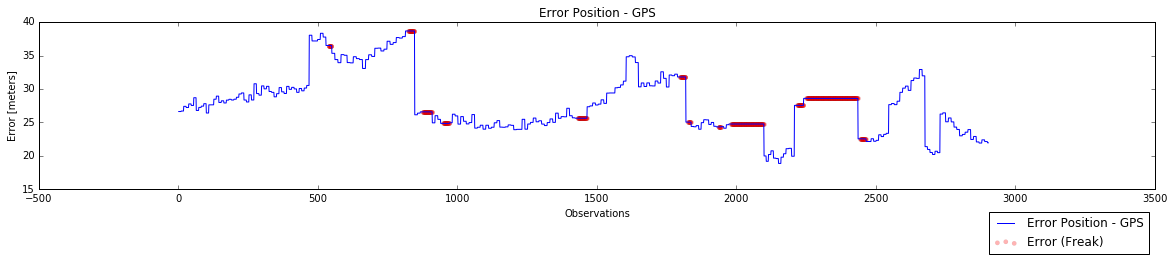

In [76]:
fig=plt.figure(figsize=(20,3))
#plt.plot(erroresGPS)
plt.ylabel("Error [meters]")
plt.xlabel("Observations")
plt.title('Error Position - GPS')
plt.plot(NumObservations, erroresGPS, c="blue", label = "Error Position - GPS")
plt.scatter(XObservationError, Errores, c="red", label = "Error (Freak)",lw=0.1,alpha=0.3)
plt.legend(loc='best', bbox_to_anchor=(1, -0.1))
plt.show()

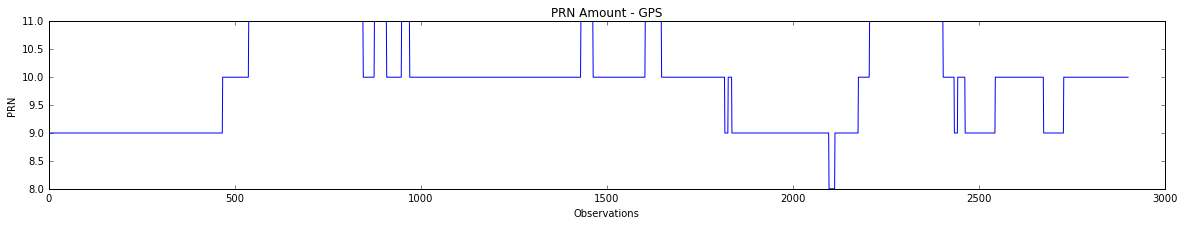

In [77]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - GPS')

### Position for <font color='blue'>GLONASS</font> -  <font color='red'>All Observations</font>

In [78]:
positionGlo = []
erroresGlo = []
c = 299792458.
SumError = 0.
vistos = []
ElevationsR = []
posXYGlo = []
sumaErroresMayoDiezmil = 0
XObservationErrorGlo = []
Errores_Glo = []
ObservationAvailability = []

for i in range (0, observations):
    if(i not in NumObservationsGlo):
        #print A_GPS.PRN[i]
        p1 = np.array(A_Glonass.P1[i])
        pos = np.array(A_Glonass.POS[i])
        clock = np.array(A_Glonass.CLOCK[i])
        vistos.append(len(A_Glonass.PRN[i]))
        ElevationsR.append(A_Glonass.ELEV[i])
        ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
        pos_cpu = ls_computed_pos[:3]
        pos_wgs = To_WGS83(pos_cpu) #from PZ.02 to WGS83
        ls_error = np.linalg.norm(pos_wgs - real_pos)
        ObservationAvailability.append(i)
        
        if ls_error<10000.: #quitar los errores de posición superiores a 10mil
            lastError = ls_error
            posXYGlo.append([pos_wgs[0],pos_wgs[1],pos_wgs[2]])
            reciverBias = pos_cpu/c
            SumError += ls_error
            positionGlo.append([pos_cpu,ls_error,reciverBias])
            erroresGlo.append(ls_error)
        else:
            sumaErroresMayoDiezmil += 1
            XObservationErrorGlo.append(i)
            Errores_Glo.append(lastError)
            erroresGlo.append(lastError)
        
names=["X","Y","Z" ]
posXYGlo = pd.DataFrame(posXYGlo, columns=names)

print "Maximum Error: ",max(erroresGlo), "[meters]"
print "Minimum Error: ",min(erroresGlo), "[meters]"
print "Errores de posición superiores a 10mil: ", sumaErroresMayoDiezmil
names = ["PosComputed","PosError","ClockBias"]
positionGlo = pd.DataFrame(positionGlo,columns=names)
print "Average Error Position for GLONASS: ", SumError/len(erroresGlo), "[meters]","how much: ",len(erroresGPS)-sumaErroresMayoDiezmil

Maximum Error:  30.3835095761 [meters]
Minimum Error:  7.41031159663 [meters]
Errores de posición superiores a 10mil:  28
Average Error Position for GLONASS:  16.0800223161 [meters] how much:  2875


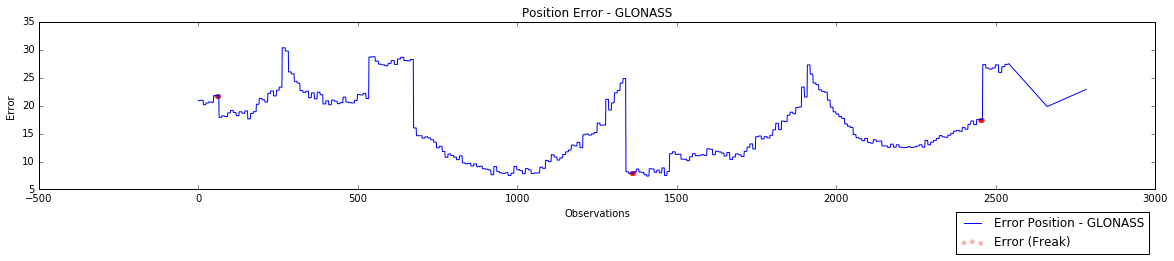

In [79]:
fig=plt.figure(figsize=(20,3))
#plt.plot(erroresGlo)
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error - GLONASS')
plt.plot(ObservationAvailability, erroresGlo, c="blue", label = "Error Position - GLONASS")
plt.scatter(XObservationErrorGlo, Errores_Glo, c="red", label = "Error (Freak)",lw=0.1,alpha=0.3)
plt.legend(loc='best', bbox_to_anchor=(1, -0.1))

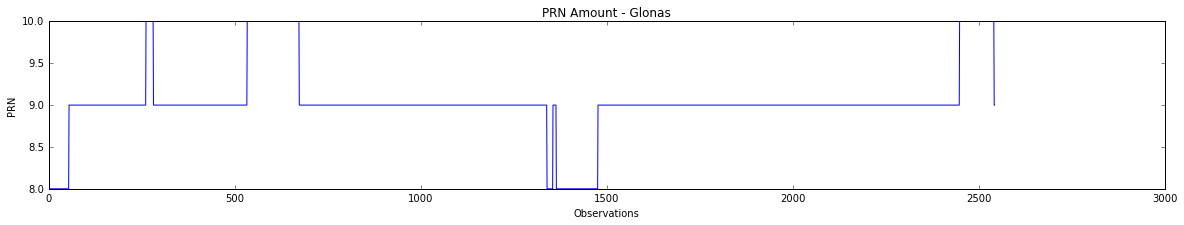

In [80]:
fig=plt.figure(figsize=(20,3))
plt.plot(vistos)
plt.ylabel("PRN")
plt.xlabel("Observations")
plt.title('PRN Amount - Glonas')

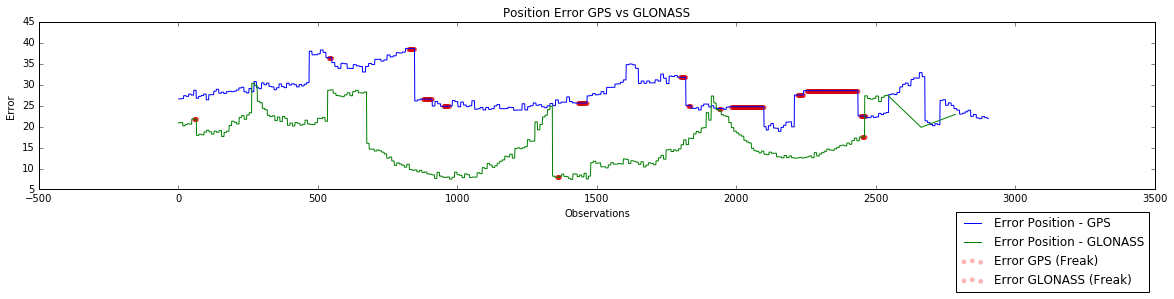

In [81]:
fig=plt.figure(figsize=(20,3))
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error GPS vs GLONASS');
plt.plot(NumObservations, erroresGPS, c="blue", label = "Error Position - GPS")
plt.plot(ObservationAvailability, erroresGlo, c="green", label = "Error Position - GLONASS")
plt.scatter(XObservationError, Errores, c="red", label = "Error GPS (Freak)",lw=0.1,alpha=0.3)
plt.scatter(XObservationErrorGlo, Errores_Glo, c="red", label = "Error GLONASS (Freak)",lw=0.1,alpha=0.3)
plt.legend(loc='best', bbox_to_anchor=(1, -0.1))

In [90]:
#ECEF to ENU
p0_geodGPS = ecef2geodetic(posXYGPS.X[0],posXYGPS.Y[0],posXYGPS.Z[0])
p0_geodGlo = ecef2geodetic(posXYGlo.X[0],posXYGlo.Y[0],posXYGlo.Z[0])
posts_enuGPS = ecef2enu(posXYGPS.X, posXYGPS.Y, posXYGPS.Z, *p0_geodGPS)
posts_enuGLO = ecef2enu(posXYGlo.X, posXYGlo.Y, posXYGlo.Z, *p0_geodGlo)

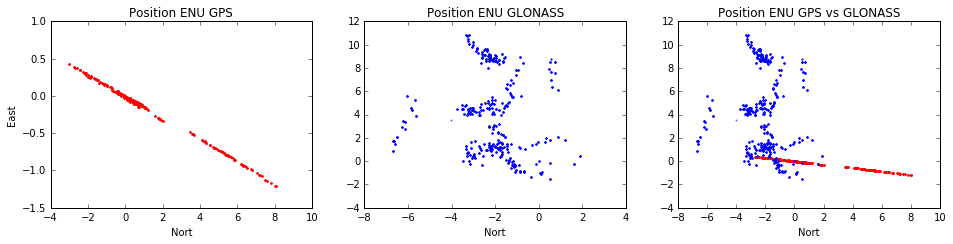

In [83]:
#fig=plt.figure(figsize=(8,8))
fig =plt.figure(figsize=(13,6))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.subplot(231)

plt.scatter(posts_enuGPS[0],posts_enuGPS[1], s=1, alpha=0.5, color = 'red')
plt.ylabel('East')
plt.xlabel('Nort')
plt.title('Position ENU GPS')

plt.subplot(232)
plt.scatter(posts_enuGLO[0],posts_enuGLO[1], s=1, alpha=0.5, color = 'blue')
plt.xlabel('Nort')
plt.title('Position ENU GLONASS')

plt.subplot(233)
plt.scatter(posts_enuGPS[0],posts_enuGPS[1], s=1, alpha=0.5, color = 'red')
plt.scatter(posts_enuGLO[0],posts_enuGLO[1], s=1, alpha=0.5, color = 'blue')
plt.xlabel('Nort')
plt.title('Position ENU GPS vs GLONASS')
plt.legend()
plt.show()

### Position for <font color='blue'>GPS</font> <font color='red'> +</font> <font color='blue'> GLONASS</font> -  <font color='red'>All Observations</font>

In [92]:
positionAll = []
erroresAll = []
c = 299792458.
SumError = 0.
vistos = []
ElevationsR = []
posXYAll = []
freakError=[]
XfreakError = []


for i in range (0, observations):
    #print A_GPS.PRN[i]
    p1 = np.array(A_Glonass.P1[i]+A_GPS.P1[i])
    pos = np.array(A_Glonass.POS[i]+A_GPS.POS[i])
    clock = np.array(A_Glonass.CLOCK[i]+A_GPS.CLOCK[i])
    vistos.append(len(A_Glonass.PRN[i]+A_GPS.PRN[i]))
    ElevationsR.append(A_Glonass.ELEV[i]+A_GPS.ELEV[i])

    ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clock, p1)
    pos_cpu = ls_computed_pos[:3]
    ls_error = np.linalg.norm(ls_computed_pos[:3] - real_pos)
    
    if ls_error<10000.: #quitar los errores de posición superiores a 10mil 
        lastError = ls_error
        posXYAll.append([ls_computed_pos[:1],ls_computed_pos[1:2],ls_computed_pos[1:2]])
        reciverBias = ls_computed_pos[3]/c
        SumError += ls_error
        positionAll.append([pos_cpu,ls_error,reciverBias])
        erroresAll.append(ls_error)
    else:
        sumaErroresMayoDiezmil += 1
        freakError.append(lastError)
        XfreakError.append(i)
        erroresAll.append(lastError)
        
names=["X","Y","Z"]
posXYAll = pd.DataFrame(posXYAll, columns=names)
print "Average Error Position for GLONASS: ", SumError/observations, "[meters]"
print "Maximum Error: ",max(erroresAll), "[meters]"
print "Minimum Error: ",min(erroresAll), "[meters]"

names = ["PosComputed","PosError","ClockBias"]
positionAll = pd.DataFrame(positionAll,columns=names)

Average Error Position for GLONASS:  19.8428745909 [meters]
Maximum Error:  33.7849920576 [meters]
Minimum Error:  15.0794306641 [meters]


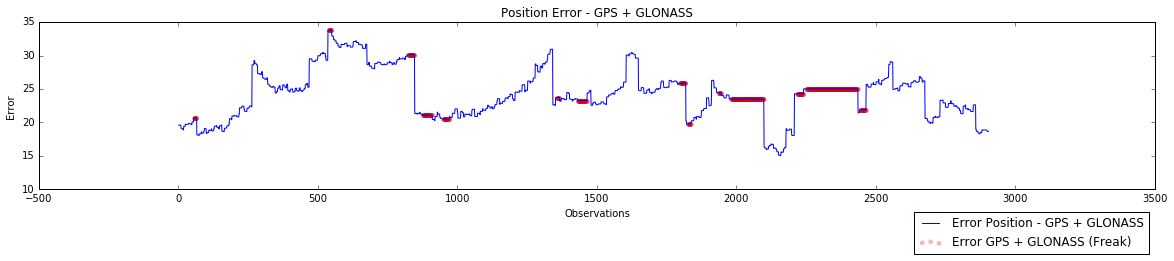

In [93]:
fig=plt.figure(figsize=(20,3))
#plt.plot(erroresAll)
plt.ylabel("Error ")
plt.xlabel("Observations")
plt.title('Position Error - GPS + GLONASS')
plt.plot(NumObservations, erroresAll, c="blue", label = "Error Position - GPS + GLONASS")
plt.scatter(XfreakError, freakError, c="red", label = "Error GPS + GLONASS (Freak)",lw=0.1,alpha=0.3)
plt.legend(loc='best', bbox_to_anchor=(1, -0.1))

In [94]:
#ECEF to ENU
p0_geodAll = ecef2geodetic(posXYAll.X[0],posXYAll.Y[0],posXYAll.Z[0])
posts_enuAll = ecef2enu(posXYAll.X, posXYAll.Y, posXYAll.Z, *p0_geodAll)

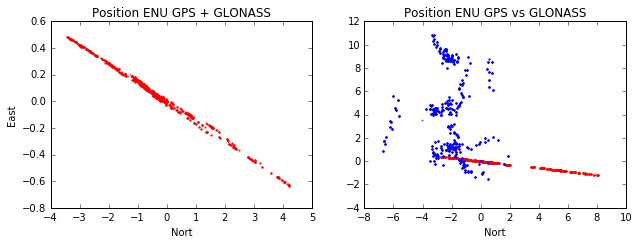

In [98]:
#fig=plt.figure(figsize=(8,8))
fig =plt.figure(figsize=(13,6))
fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)

plt.subplot(231)

plt.scatter(posts_enuAll[0],posts_enuAll[1], s=1, alpha=0.5, color = 'red')
plt.ylabel('East')
plt.xlabel('Nort')
plt.title('Position ENU GPS + GLONASS')

plt.subplot(232)
plt.scatter(posts_enuGPS[0],posts_enuGPS[1], s=1, alpha=0.5, color = 'red')
plt.scatter(posts_enuGLO[0],posts_enuGLO[1], s=1, alpha=0.5, color = 'blue')
plt.xlabel('Nort')
plt.title('Position ENU GPS vs GLONASS')
plt.legend()
plt.show()